In [1]:
#IMPORT CELL
import pandas as pd
import string 
import re
from collections import Counter
from scipy.spatial import distance
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

In [2]:
#Part 1
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stop_words = pd.read_fwf('stop_words.txt')

def is_not_float(string):
    try:
        float(string)
        return False
    except ValueError:  # String is not a number
        return True
    
def wordfreq(tweet):
    tweetlist = tweet.split()
    count = tweetlist.count(word)
    return count

In [3]:
#Train Cleaning

# Removing URLS
train['Tweet'] = train['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#To Lowercase
train['Tweet'] = train['Tweet'].str.lower()

#Removing stopwords
sw_list = stop_words['i'].tolist()
train['Tweet'] = train['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw_list)]))

#Removing Punctuation
train['Tweet'] = train['Tweet'].str.replace('[{}]'.format(string.punctuation), '')

# #Removing single characters
# train['Tweet'] = train['Tweet'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

#Removing Numbers
# train["Tweet"] = train["Tweet"].apply(lambda x: ' '.join([i for i in x.split() if is_not_float(i)]))


# display(train.head())

In [4]:
#Test Cleaning

#Removing URLS
test['Tweet'] = test['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

#To Lowercase
test['Tweet'] = test['Tweet'].str.lower()

#Removing stopwords
sw_list = stop_words['i'].tolist()
test['Tweet'] = test['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw_list)]))

#Removing Punctuation
test['Tweet'] = test['Tweet'].str.replace('[{}]'.format(string.punctuation), '')

# #Removing single characters
# test['Tweet'] = test['Tweet'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

#Removing Numbers
# test["Tweet"] = test["Tweet"].apply(lambda x: ' '.join([i for i in x.split() if is_not_float(i)]))

# display(test.head())

In [5]:
#Making BOW representation of train

#Making vocab from train
all_text = ' '.join(train['Tweet'].tolist())

vocab = list(set(all_text.split()))



tweets = ['T' + str(i) for i in range(len(train))]

BOWTrain = pd.DataFrame(tweets, columns =['Tweet'])




for word in vocab:


    BOWTrain[word] = train.apply(lambda row: wordfreq(row["Tweet"]),axis=1)
    
    

        
BOWTrain['Sentiment'] = train['Sentiment']










In [6]:
#Making BOW representation of test

tweets = ['T' + str(i) for i in range(len(test))]

BOWTest = pd.DataFrame(tweets, columns =['Tweet'])




for word in vocab:
    BOWTest[word] = test.apply(lambda row: wordfreq(row["Tweet"]),axis=1)
    

        
BOWTest['Sentiment'] = test['Sentiment']







In [7]:
TrainFeatures = BOWTrain.drop(['Tweet', 'Sentiment'], 1)
TestFeatures = BOWTest.drop(['Tweet', 'Sentiment'], 1)
   


In [8]:
#Calculating euclidean distances of test with train
distances = distance.cdist(TestFeatures,TrainFeatures ,'euclidean')





In [9]:
#Predicting Labels

distances = np.array(distances)

ks = {1,3,5,7,10}
trainlabels = BOWTrain["Sentiment"].tolist()

predictedlabelsForEachK = []


for k in ks:
    predictedlabels = []
    for distanceVector in distances:
        
        label_distances = list(map(lambda x, y:(x,y), trainlabels, distanceVector))

        sorted_label_distances = sorted(label_distances, key = lambda x: x[1]) 

        while k >= 1:


            nns = sorted_label_distances[:k]
            counts = Counter(x[0] for x in nns)
            c1 = counts['positive']
            c2 = counts['negative']
            c3 = counts['neutral']

       

            if c1 == c2 == c3:
                k-=1

            elif c1 == c2 and c1 > c3 and c2 > c3:
                k-=1

            elif c1 == c3 and c1 > c2 and c3 > c2:
                k-=1

            elif c2 == c3 and c2 > c1 and c3 > c1:
                k-=1

            elif c2 == c3 and c2 < c1 and c3 < c1:
                #c1
                predictedlabels.append('positive')
                break

            elif c1 == c3 and c1 < c2 and c3 < c2:
                #c2
                predictedlabels.append('negative')
                break
            elif c2 == c3 and c2 < c1 and c3 < c1:
                #c3
                predictedlabels.append('neutral')
                break
            elif c1 > c2 and c1 > c3:
                #c1
                predictedlabels.append('positive')
                break
            elif c2 > c1 and c2 > c3: 
                #c2
                predictedlabels.append('negative')
                break

            elif c3 > c1 and c3 > c2:   
                #c3
                predictedlabels.append('neutral')
                break

    
        


    prediction = pd.DataFrame({'Predicted Sentiment':predictedlabels})
    prediction["Actual Sentiment"] = test["Sentiment"]

    
    predictedlabelsForEachK.append(prediction)
    


In [10]:
#accuracies

def f(col1, col2):
    if col1 == col2:
        return 1
    else:
        return 0

accuracies = []
for i,k in enumerate(ks):
    prediction = predictedlabelsForEachK[i]

    temp = prediction

    temp["Count"] = temp.apply(lambda x: f(x['Predicted Sentiment'], x['Actual Sentiment']), axis=1)


    matches = temp["Count"].sum()
    samples = prediction.shape[0]

    accuracy = matches / samples
    
    accuracies.append(accuracy)

display(accuracies)

[0.5111263266004793,
 0.5111263266004793,
 0.5107839780896953,
 0.5104416295789114,
 0.5097569325573433]

In [11]:
#cms
def g(col1, col2, cm):
    if col1 == "positive" and col2 == "positive":
        cm.at['pos', 'pos'] += 1
    elif col1 == "positive" and col2 == "negative":
        cm.at['pos','neg'] +=1
    elif col1 == "positive" and col2 == "neutral":
        cm.at['pos','neu'] +=1
    elif col1 == "negative" and col2 == "positive":
        cm.at['neg','pos'] +=1
    elif col1 == "negative" and col2 == "negative":
        cm.at['neg','neg'] +=1   
    elif col1 == "negative" and col2 == "neutral":
        cm.at['neg','neu'] +=1   
    elif col1 == "neutral" and col2 == "positive":
        cm.at['neu','pos'] +=1
    elif col1 == "neutral" and col2 == "negative":
        cm.at['neu','neg'] +=1
    elif col1 == "neutral" and col2 == "neutral":
        cm.at['neu','neu'] +=1

        
        
    
cms = []
for i,k in enumerate(ks):
     prediction = predictedlabelsForEachK[i]

     cm = pd.DataFrame(index=['pos','neg','neu'], columns=['pos','neg','neu'])
     cm = cm.fillna(0)
     
    
        
     
     prediction.apply(lambda x: g(x['Predicted Sentiment'], x['Actual Sentiment'],cm), axis=1) 
     
     display(cm)
     cms.append(cm)


,pos,neg,neu
pos,260,250,152
neg,50,881,111
neu,162,703,352


,pos,neg,neu
pos,260,250,152
neg,50,881,111
neu,162,703,352


,pos,neg,neu
pos,261,250,152
neg,50,879,111
neu,161,705,352


,pos,neg,neu
pos,261,249,151
neg,50,877,111
neu,161,708,353


,pos,neg,neu
pos,260,251,151
neg,50,876,111
neu,162,707,353


In [12]:
#precisions, recalls and f1s
classes = ['pos','neg','neu']
precisions = []
recalls = []
f1s = []
ks = [1,3,5,7,10]
for cm in cms:
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    precision = 0
    recall = 0
    f1 = 0
    for c in classes:
        if c == 'pos':
            tp = cm.at['pos','pos']
            tn = cm.at['neg','neg'] + cm.at['neg','neu'] + cm.at['neu','neg'] + cm.at['neu','neu']
            fp = cm.at['pos','neg'] + cm.at['pos','neu']
            fn = cm.at['neg','pos'] + cm.at['neu','pos']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
        elif c == 'neg':
            tp = cm.at['neg','neg']
            tn = cm.at['pos','pos'] + cm.at['pos','neu'] + cm.at['neu','pos'] + cm.at['neu','neu']
            fp = cm.at['neg','pos'] + cm.at['neg','neu']
            fn = cm.at['pos','neg'] + cm.at['neu','neg']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
            
        elif c == 'neu':
            tp = cm.at['neu','neu']
            tn = cm.at['pos','pos'] + cm.at['pos','neg'] + cm.at['neg','pos'] + cm.at['neg','neg']
            fp = cm.at['neu','neg'] + cm.at['neu','pos']
            fn = cm.at['pos','neu'] + cm.at['neg','neu']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
            
    
    precisions.append(precision / 3)
    recalls.append(recall / 3)
    f1s.append(f1 / 3)

display(accuracies)
display(precisions)
display(recalls)
display(f1s)
        

[0.5111263266004793,
 0.5111263266004793,
 0.5107839780896953,
 0.5104416295789114,
 0.5097569325573433]

[0.5091581712974201,
 0.5091581712974201,
 0.5092852746757411,
 0.5095403363684615,
 0.5087881345454749]

[0.5345253184894195,
 0.5345253184894195,
 0.534868028998387,
 0.5350465302381431,
 0.5341585634587285]

[0.4851632450617915,
 0.4851632450617915,
 0.4852242493719929,
 0.48525674694073756,
 0.48437213027572534]

Text(0.5, 1.0, 'k against Accuracy')

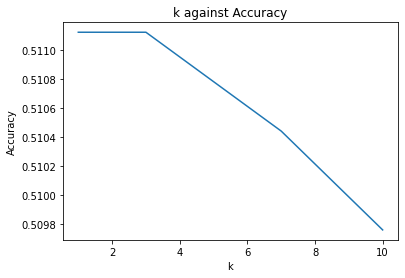

In [13]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')

Text(0.5, 1.0, 'k against Precision')

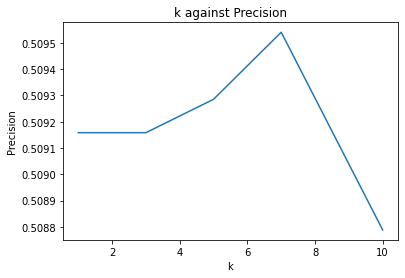

In [14]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

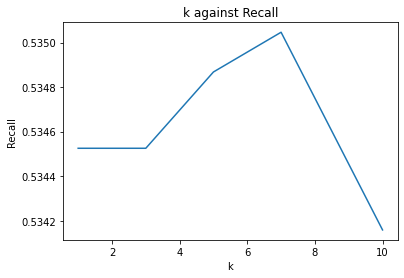

In [15]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

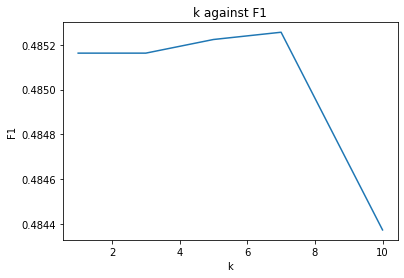

In [16]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')

In [17]:
#Part 2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
target_names = ['positive', 'negative', 'neutral']
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []
ks = [1,3,5,7,10]

for k in ks:

    TrainFeatures = BOWTrain.drop(['Tweet', 'Sentiment'], 1)
    TrainFeatures = TrainFeatures.values.tolist()
    TrainLabels = BOWTrain['Sentiment'].tolist()

    TestFeatures = BOWTest.drop(['Tweet', 'Sentiment'], 1)
    TestFeatures = TestFeatures.values.tolist()

    TrueLabels = BOWTest['Sentiment'].tolist()

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(TrainFeatures, TrainLabels)

    predicted_labels = neigh.predict(TestFeatures)
    accuracy = accuracy_score(TrueLabels, predicted_labels)
    accuracies.append(accuracy)
    
    report_dict = classification_report(TrueLabels, predicted_labels, target_names=target_names, output_dict=True)
    precision = report_dict['macro avg']['precision']
    precisions.append(precision)
    recall = report_dict['macro avg']['recall']
    recalls.append(recall)
    f1 = report_dict['macro avg']['f1-score']
    f1s.append(f1)
    
    cm = confusion_matrix(TrueLabels, predicted_labels, labels=["positive", "negative", "neutral"])
    cms.append(cm)

display(cms)
display(accuracies)
display(precisions)
display(recalls)
display(f1s)


[array([[283,  57, 132],
        [295, 863, 676],
        [170, 130, 315]]),
 array([[285,  81, 106],
        [231, 958, 645],
        [129, 167, 319]]),
 array([[265,  62, 145],
        [195, 907, 732],
        [114, 148, 353]]),
 array([[264,  52, 156],
        [238, 823, 773],
        [122, 143, 350]]),
 array([[277,  43, 152],
        [343, 736, 755],
        [144, 115, 356]])]

[0.500171174255392,
 0.5347483738445737,
 0.5220814789455666,
 0.49195480999657654,
 0.468675111263266]

[0.4935818907287139,
 0.5114509439808613,
 0.5202202542552348,
 0.501725383426307,
 0.4892334103899159]

[0.5274425181778387,
 0.5482894178007451,
 0.5433239516996763,
 0.525724545177729,
 0.5223449368155401]

[0.4749647943574895,
 0.5063978689767595,
 0.5013516220647266,
 0.4761596159752834,
 0.45564541270153286]

Text(0.5, 1.0, 'k against Accuracy')

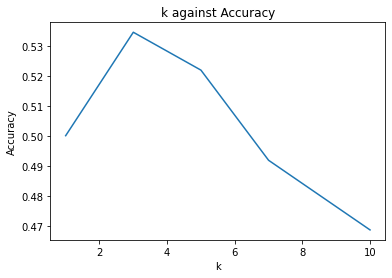

In [18]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')




Text(0.5, 1.0, 'k against Precision')

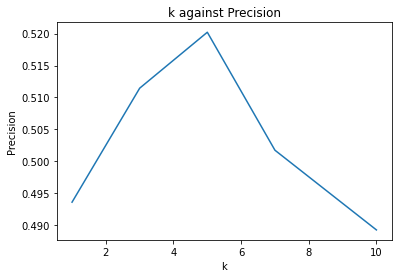

In [19]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

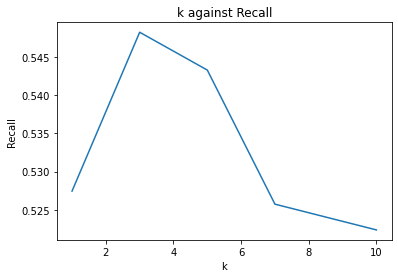

In [20]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

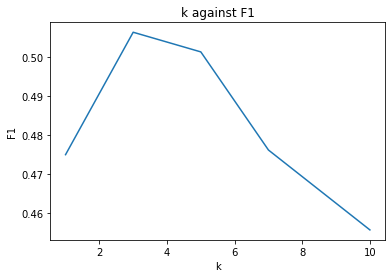

In [21]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')

In [22]:
#Part 3
from gensim.models import KeyedVectors
import numpy as np

def extract_features(text):
  words = [word for word in text.split() if word in word2vec.vocab]
  return np.mean(word2vec[words], axis=0)

word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)





In [23]:
#word2vec for train
tweets = ['T' + str(i) for i in range(len(train))]

w2vTrain = pd.DataFrame(tweets, columns =['Tweet'])

w2vTrain['Features'] = train.apply(lambda row: extract_features(row["Tweet"]),axis=1)



w2vTrain['Sentiment'] = train['Sentiment']

display(w2vTrain)

,Tweet,Features,Sentiment
0,T0,"[-0.049743652, 0.009765625, 0.016052246, 0.254...",neutral
1,T1,"[-0.04901123, 0.014404297, -0.03338623, 0.1102...",negative
2,T2,"[0.0037750243, 0.0413723, -0.0053283693, 0.021...",positive
3,T3,"[0.07572937, -0.060114544, 0.0022684734, 0.022...",negative
4,T4,"[0.04239909, -0.030232748, 0.063201904, 0.1782...",negative
...,...,...,...
11675,T11675,"[0.033396404, 0.062032063, 0.10052109, -0.0342...",negative
11676,T11676,"[-0.0014038086, 0.026733398, 0.106544495, 0.01...",negative
11677,T11677,"[0.004248047, 0.068408206, 0.04409485, 0.17875...",neutral
11678,T11678,"[0.06571139, 0.010967548, 0.0023249113, 0.1097...",negative


In [24]:
#word2vec for test
tweets = ['T' + str(i) for i in range(len(test))]

w2vTest = pd.DataFrame(tweets, columns =['Tweet'])

w2vTest['Features'] = test.apply(lambda row: extract_features(row["Tweet"]),axis=1)



w2vTest['Sentiment'] = test['Sentiment']

display(w2vTest)

,Tweet,Features,Sentiment
0,T0,"[-0.052124023, -0.025878906, -0.1665039, -0.05...",neutral
1,T1,"[-0.01133728, 0.011459351, 0.006072998, 0.1003...",positive
2,T2,"[-0.04442342, 0.0035807292, -0.09275309, 0.146...",negative
3,T3,"[0.049312048, -0.0030343193, -0.051108222, 0.0...",negative
4,T4,"[0.06750488, 0.13303375, 0.004333496, 0.142150...",negative
...,...,...,...
2916,T2916,"[0.00789388, -0.016316732, 0.023885092, 0.0580...",negative
2917,T2917,"[-0.051171876, 0.023046875, 0.034448244, 0.115...",neutral
2918,T2918,"[-0.11027832, -0.0024414062, 0.009741211, 0.06...",negative
2919,T2919,"[-0.028148651, 0.022649765, -0.006084442, 0.11...",negative


In [25]:
#Running Part 1 with word2vec

In [26]:
#Calculating euclidean distances
TrainFeatures = w2vTrain['Features'].tolist()
TestFeatures = w2vTest['Features'].tolist()

distances = distance.cdist(TestFeatures,TrainFeatures,'euclidean')


In [27]:
#Predicting Labels

distances = np.array(distances)

ks = {1,3,5,7,10}
trainlabels = w2vTrain["Sentiment"].tolist()

predictedlabelsForEachK = []

for k in ks:
    predictedlabels = []
    for distanceVector in distances:
        
        label_distances = list(map(lambda x, y:(x,y), trainlabels, distanceVector))

        sorted_label_distances = sorted(label_distances, key = lambda x: x[1]) 

        while k >= 1:


            nns = sorted_label_distances[:k]
            counts = Counter(x[0] for x in nns)
            c1 = counts['positive']
            c2 = counts['negative']
            c3 = counts['neutral']

       

            if c1 == c2 == c3:
                k-=1

            elif c1 == c2 and c1 > c3 and c2 > c3:
                k-=1

            elif c1 == c3 and c1 > c2 and c3 > c2:
                k-=1

            elif c2 == c3 and c2 > c1 and c3 > c1:
                k-=1

            elif c2 == c3 and c2 < c1 and c3 < c1:
                #c1
                predictedlabels.append('positive')
                break

            elif c1 == c3 and c1 < c2 and c3 < c2:
                #c2
                predictedlabels.append('negative')
                break
            elif c2 == c3 and c2 < c1 and c3 < c1:
                #c3
                predictedlabels.append('neutral')
                break
            elif c1 > c2 and c1 > c3:
                #c1
                predictedlabels.append('positive')
                break
            elif c2 > c1 and c2 > c3: 
                #c2
                predictedlabels.append('negative')
                break

            elif c3 > c1 and c3 > c2:   
                #c3
                predictedlabels.append('neutral')
                break

    
        


    prediction = pd.DataFrame({'Predicted Sentiment':predictedlabels})
    prediction["Actual Sentiment"] = test["Sentiment"]

    predictedlabelsForEachK.append(prediction)
    


In [28]:
#accuracies

def f(col1, col2):
    if col1 == col2:
        return 1
    else:
        return 0

accuracies = []
for i,k in enumerate(ks):
    prediction = predictedlabelsForEachK[i]


    temp = prediction

    temp["Count"] = temp.apply(lambda x: f(x['Predicted Sentiment'], x['Actual Sentiment']), axis=1)


    matches = temp["Count"].sum()
    samples = prediction.shape[0]

    accuracy = matches / samples
    
    accuracies.append(accuracy)

display(accuracies)

[0.7004450530640192,
 0.7021567956179391,
 0.7021567956179391,
 0.7011297500855871,
 0.7011297500855871]

In [29]:
#cms
def g(col1, col2, cm):
    if col1 == "positive" and col2 == "positive":
        cm.at['pos', 'pos'] += 1
    elif col1 == "positive" and col2 == "negative":
        cm.at['pos','neg'] +=1
    elif col1 == "positive" and col2 == "neutral":
        cm.at['pos','neu'] +=1
    elif col1 == "negative" and col2 == "positive":
        cm.at['neg','pos'] +=1
    elif col1 == "negative" and col2 == "negative":
        cm.at['neg','neg'] +=1   
    elif col1 == "negative" and col2 == "neutral":
        cm.at['neg','neu'] +=1   
    elif col1 == "neutral" and col2 == "positive":
        cm.at['neu','pos'] +=1
    elif col1 == "neutral" and col2 == "negative":
        cm.at['neu','neg'] +=1
    elif col1 == "neutral" and col2 == "neutral":
        cm.at['neu','neu'] +=1

        
        
    
cms = []
for i,k in enumerate(ks):
     prediction = predictedlabelsForEachK[i]

     cm = pd.DataFrame(index=['pos','neg','neu'], columns=['pos','neg','neu'])
     cm = cm.fillna(0)
     
    
        
     
     prediction.apply(lambda x: g(x['Predicted Sentiment'], x['Actual Sentiment'],cm), axis=1) 
     
     display(cm)
     cms.append(cm)


,pos,neg,neu
pos,236,108,74
neg,149,1564,295
neu,87,162,246


,pos,neg,neu
pos,236,106,74
neg,149,1569,295
neu,87,159,246


,pos,neg,neu
pos,237,106,74
neg,150,1570,297
neu,85,158,244


,pos,neg,neu
pos,237,106,73
neg,151,1571,302
neu,84,157,240


,pos,neg,neu
pos,237,105,73
neg,150,1573,304
neu,85,156,238


In [30]:
#precisions, recalls and f1s
classes = ['pos','neg','neu']
precisions = []
recalls = []
f1s = []
ks = [1,3,5,7,10]
for cm in cms:
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    precision = 0
    recall = 0
    f1 = 0
    for c in classes:
        if c == 'pos':
            tp = cm.at['pos','pos']
            tn = cm.at['neg','neg'] + cm.at['neg','neu'] + cm.at['neu','neg'] + cm.at['neu','neu']
            fp = cm.at['pos','neg'] + cm.at['pos','neu']
            fn = cm.at['neg','pos'] + cm.at['neu','pos']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
        elif c == 'neg':
            tp = cm.at['neg','neg']
            tn = cm.at['pos','pos'] + cm.at['pos','neu'] + cm.at['neu','pos'] + cm.at['neu','neu']
            fp = cm.at['neg','pos'] + cm.at['neg','neu']
            fn = cm.at['pos','neg'] + cm.at['neu','neg']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
            
        elif c == 'neu':
            tp = cm.at['neu','neu']
            tn = cm.at['pos','pos'] + cm.at['pos','neg'] + cm.at['neg','pos'] + cm.at['neg','neg']
            fp = cm.at['neu','neg'] + cm.at['neu','pos']
            fn = cm.at['pos','neu'] + cm.at['neg','neu']
            precision += tp / (tp + fp)
            recall += tp / (tp + fn)
            f1 += (2*tp) / (2*tp + fp + fn)
            
    
    precisions.append(precision / 3)
    recalls.append(recall / 3)
    f1s.append(f1 / 3)

display(accuracies)
display(precisions)
display(recalls)
display(f1s)
        

[0.7004450530640192,
 0.7021567956179391,
 0.7021567956179391,
 0.7011297500855871,
 0.7011297500855871]

[0.613482486852166,
 0.6155804577935725,
 0.6159185853370895,
 0.6149526027243418,
 0.6146588312189282]

[0.5842602689930935,
 0.5851690294438385,
 0.5849729853831448,
 0.5829867157930769,
 0.5822662091332667]

[0.5959132046434422,
 0.5972255072852941,
 0.59712906617918,
 0.5953838667992214,
 0.594766977531907]

Text(0.5, 1.0, 'k against Accuracy')

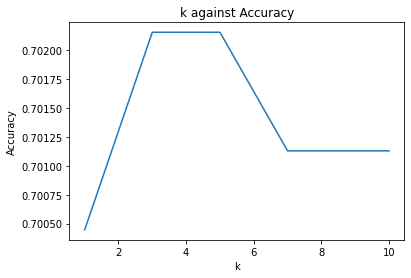

In [31]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')

Text(0.5, 1.0, 'k against Precision')

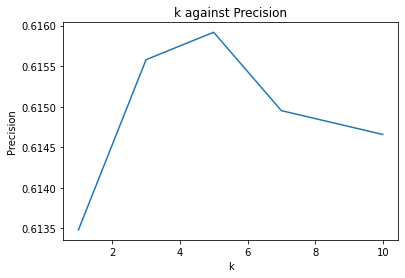

In [32]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

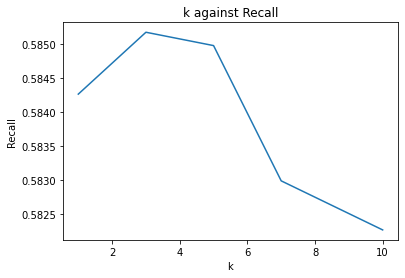

In [33]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

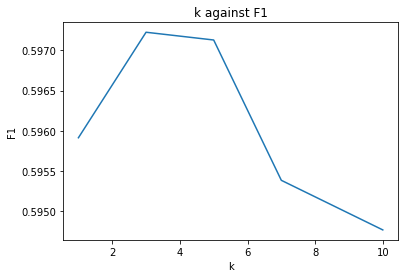

In [34]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')

In [35]:
#Running Part 2 with word2vec

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
target_names = ['positive', 'negative', 'neutral']
accuracies = []
precisions = []
recalls = []
f1s = []
cms = []
ks = [1,3,5,7,10]

for k in ks:

    TrainFeatures = w2vTrain.drop(['Tweet', 'Sentiment'], 1)
    TrainFeatures = TrainFeatures['Features'].tolist()
    TrainLabels = w2vTrain['Sentiment'].tolist()

    TestFeatures = w2vTest.drop(['Tweet', 'Sentiment'], 1)
    TestFeatures = TestFeatures['Features'].tolist()

    TrueLabels = w2vTest['Sentiment'].tolist()

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(TrainFeatures, TrainLabels)

    predicted_labels = neigh.predict(TestFeatures)
    accuracy = accuracy_score(TrueLabels, predicted_labels)
    accuracies.append(accuracy)
    
    report_dict = classification_report(TrueLabels, predicted_labels, target_names=target_names, output_dict=True)
    precision = report_dict['macro avg']['precision']
    precisions.append(precision)
    recall = report_dict['macro avg']['recall']
    recalls.append(recall)
    f1 = report_dict['macro avg']['f1-score']
    f1s.append(f1)
    
    cm = confusion_matrix(TrueLabels, predicted_labels, labels=["positive", "negative", "neutral"])
    cms.append(cm)

display(cms)
display(accuracies)
display(precisions)
display(recalls)
display(f1s)


[array([[ 246,  149,   77],
        [ 109, 1566,  159],
        [  78,  294,  243]]),
 array([[ 234,  189,   49],
        [  38, 1722,   74],
        [  55,  390,  170]]),
 array([[ 220,  209,   43],
        [  22, 1761,   51],
        [  36,  439,  140]]),
 array([[ 221,  212,   39],
        [  18, 1781,   35],
        [  38,  436,  141]]),
 array([[ 202,  235,   35],
        [  10, 1806,   18],
        [  36,  461,  118]])]

[0.7035261896610749,
 0.7278329339267374,
 0.7261211913728175,
 0.733652858610065,
 0.7278329339267374]

[0.6183095014418752,
 0.6813904607420761,
 0.7068887406918352,
 0.7289571457639771,
 0.7421323835102829]

[0.5900599038058844,
 0.5703722579339909,
 0.5513134211984597,
 0.5561966831107603,
 0.5348562816071943]

[0.6009586718361574,
 0.5976904893792873,
 0.5821798308694955,
 0.5884803357631552,
 0.5647971314318742]

Text(0.5, 1.0, 'k against Accuracy')

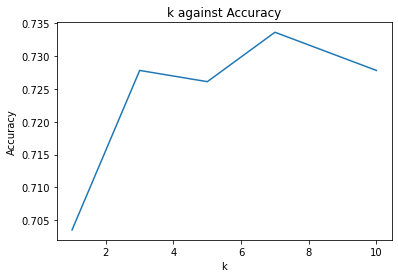

In [37]:
#k vs accuracy
plt.plot(ks, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k against Accuracy')



Text(0.5, 1.0, 'k against Precision')

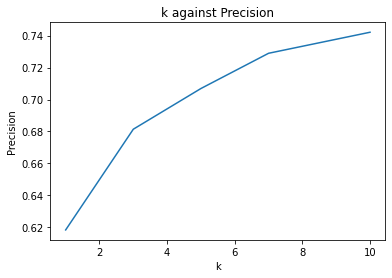

In [38]:
#k vs precision
plt.plot(ks, precisions)
plt.xlabel('k')
plt.ylabel('Precision')
plt.title('k against Precision')

Text(0.5, 1.0, 'k against Recall')

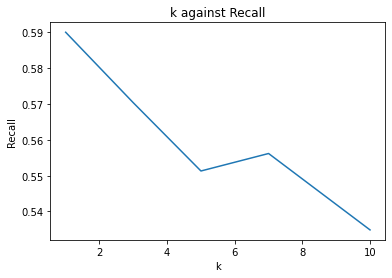

In [39]:
#k vs recall
plt.plot(ks, recalls)
plt.xlabel('k')
plt.ylabel('Recall')
plt.title('k against Recall')

Text(0.5, 1.0, 'k against F1')

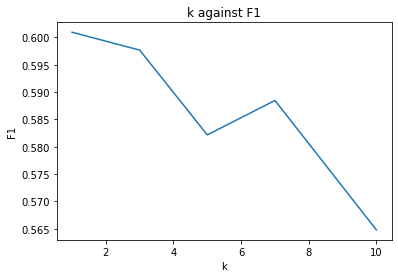

In [40]:
#k vs f1
plt.plot(ks, f1s)
plt.xlabel('k')
plt.ylabel('F1')
plt.title('k against F1')